In [1]:
import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import PIL

import random
import tensorflow as tf
import tensorflow_addons as tfa
from keras_preprocessing.image import ImageDataGenerator

from pathlib import Path
from glob import glob
from random import randrange

from collections import defaultdict
from openslide import OpenSlide

from tensorflow.keras import layers, models, Model, Input, backend
from keras.models import Sequential
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from skimage.exposure import is_low_contrast
from collections import defaultdict
from skimage.io import imread
from PIL import Image
from pathlib import Path
from tqdm import tqdm

random.seed(19)
tf.random.set_seed(19)

In [2]:
orig_data_path='../input/mayo-clinic-strip-ai/'

train_path = orig_data_path + 'train/'
other_path = orig_data_path + 'other/'

In [3]:
train_csv_data = pd.read_csv(orig_data_path + 'train.csv')
other_csv_data = pd.read_csv(orig_data_path + 'other.csv')

In [4]:
other_csv_data.head()

,image_id,patient_id,image_num,other_specified,label
0,01f2b3_0,01f2b3,0,NaN,Unknown
1,01f2b3_1,01f2b3,1,NaN,Unknown
2,02ebd5_0,02ebd5,0,NaN,Unknown
3,0412ab_0,0412ab,0,NaN,Unknown
4,04414e_0,04414e,0,Hypercoagulable,Other


In [5]:
train_csv_data.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In [6]:
path_train_images = '../input/mayo-clinic-tiles/output/train/tiles2/'
train_ids = next(os.walk(path_train_images))[2]
img_list = os.listdir('../input/mayo-clinic-tiles/output/train/tiles2/')

(224, 224)


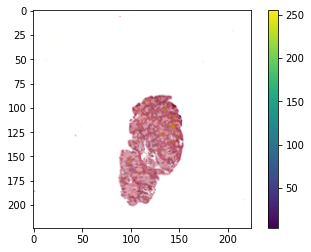

In [7]:
def show(path):
    image = Image.open(path_train_images + path)
    print(image.size)
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()
    
show(img_list[0])

In [8]:
# function to check if the image contains useful information after the crop.
def get_score(img):
    imgray = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #print(len(hierarchy[0]), len(contours))
    return len(contours)

In [9]:
low_sc_images = []
def load_train_df():
    train_df = defaultdict(list)
    img_indx = 0
    print('Loading train images...')
    for i, proc_image_id in tqdm(enumerate(train_ids), total=len(train_ids)):
        fnames = ['0ba49d_0', '0ba49d_0', '006388_0']   
        if any(f in proc_image_id for f in fnames):
            continue
        if(train_csv_data.loc[train_csv_data['image_id'] == proc_image_id[:-8]].empty):
            continue
            
        label = train_csv_data.loc[train_csv_data['image_id'] == proc_image_id[:-8]]['label'].item()
        center_id = train_csv_data.loc[train_csv_data['image_id'] == proc_image_id[:-8]]['center_id'].item()
        
        path_tiles = path_train_images + proc_image_id
        train_df['image_id'].append(proc_image_id)
        train_df['label'].append(label)
        img_indx += 1
                
    return pd.DataFrame(train_df)

In [10]:
train_df = load_train_df()

Loading train images...


100%|██████████| 4323/4323 [00:06<00:00, 639.26it/s]


In [11]:
train_df['label'].value_counts()

LAA    2195
CE     2118
Name: label, dtype: int64

In [12]:
def show_crop(image):
#    image = Image.open(path_train_crops + path)
    image = np.asarray(image)
    print('is_low_contrast', is_low_contrast(image))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
# show_crop(low_sc_images[7])
# #len(low_sc_images)

In [13]:
IMG_SIZE = 224

In [14]:
image_shape = (IMG_SIZE, IMG_SIZE)

datagen=ImageDataGenerator(rescale=1./255,
                           zoom_range=0.2,
                           rotation_range=20,
                           validation_split=0.2)
train_gen = datagen.flow_from_dataframe(
                         train_df,
                         directory=path_train_images,
                         x_col = 'image_id',
                         y_col = 'label',
                         target_size=image_shape,
                         class_mode = 'sparse',
                         color_mode = 'rgb',
                         shuffle=True,
                         batch_size=16,
                         seed=19,
                         subset='training')
validation_gen = datagen.flow_from_dataframe(
                         train_df,
                         directory=path_train_images,
                         x_col = 'image_id',
                         y_col = 'label',
                         target_size=image_shape,
                         class_mode = 'sparse',
                         color_mode = 'rgb',
                         shuffle=True,
                         batch_size=16,
                         seed=19,
                         subset='validation')

Found 3451 validated image filenames belonging to 2 classes.
Found 862 validated image filenames belonging to 2 classes.


In [15]:
train_gen.class_indices

{'CE': 0, 'LAA': 1}

In [16]:
from keras import models

from tensorflow.keras import layers, Model

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:

    
    
    # Load InceptionV3 as the base model
    
    inception_model = tf.keras.applications.InceptionV3(
    
        include_top=False,            # Exclude the top layers (fully connected)
    
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    
        pooling='avg',                # Global average pooling for a 1D output
    
        weights='imagenet'            # Load pretrained weights
    
    )
    
    
    
    # Freeze most of the base model layers, but unfreeze the last few
    
    for layer in inception_model.layers:  
    
        layer.trainable = False
    
    # Build the model using the Functional API
    
    inputs = inception_model.input
    
    x = inception_model.output
    
    
    
    
    
    x = layers.Dense(256)(x)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    
    x = layers.Dropout(0.5)(x)
    
    
    
    # Final output layer for binary classification
    
    outputs = layers.Dense(2, activation='softmax')(x)
    
    
    
    # Create the final model
    
    inception_model = Model(inputs=inputs, outputs=outputs)
    
    
    
    # Print the summary
    
    inception_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1,mode='min',patience=3, min_lr=1E-6)

inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = inception_model.fit(train_gen, epochs=20, shuffle=True, validation_data=validation_gen, callbacks=[reduce_lr])


Epoch 1/20
216/216 [==============================] - 78s 312ms/step - loss: 0.9467 - accuracy: 0.5335 - val_loss: 0.7022 - val_accuracy: 0.6125
Epoch 2/20
216/216 [==============================] - 57s 265ms/step - loss: 0.7910 - accuracy: 0.5975 - val_loss: 0.6696 - val_accuracy: 0.6137
Epoch 3/20
216/216 [==============================] - 54s 249ms/step - loss: 0.7441 - accuracy: 0.6230 - val_loss: 0.6205 - val_accuracy: 0.6682
Epoch 4/20
216/216 [==============================] - 48s 223ms/step - loss: 0.6928 - accuracy: 0.6465 - val_loss: 0.5975 - val_accuracy: 0.6949
Epoch 5/20
216/216 [==============================] - 49s 228ms/step - loss: 0.6879 - accuracy: 0.6442 - val_loss: 0.6097 - val_accuracy: 0.6694
Epoch 6/20
216/216 [==============================] - 53s 243ms/step - loss: 0.6448 - accuracy: 0.6728 - val_loss: 0.6808 - val_accuracy: 0.6427
Epoch 7/20
216/216 [==============================] - 52s 241ms/step - loss: 0.6308 - accuracy: 0.6755 - val_loss: 0.5716 - val_ac

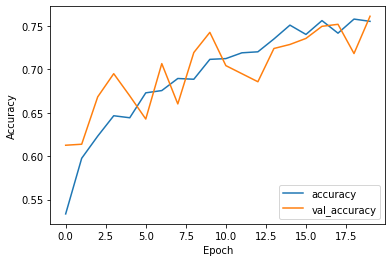

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.legend(loc='lower right')

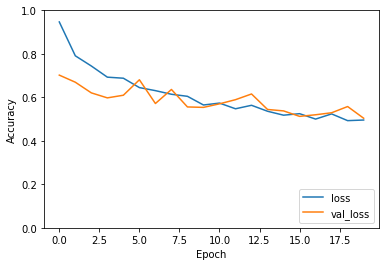

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [24]:
inception_model.save('inception1.h5')